In [1]:
import json
file_path = 'dev-sample.jsonl'
dataset = []
with open(file_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        dataset.append(data)

In [2]:
from utils.preprocess import write_jsonl, preprocess_NQ
processed_dataset = preprocess_NQ(dataset)
write_jsonl('processed_data/evaluation_dataset.jsonl', processed_dataset)

In [1]:
from retrieval_judge import RetrievalJudge
retrieval_judge = RetrievalJudge()

In [3]:
all_texts = retrieval_judge.get_pages()

In [6]:
for i,txt in enumerate(all_texts):
    with open(f'articles/{i}.txt', 'w') as file:
        file.write(txt)


### With Llama Index

In [7]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter

documents = SimpleDirectoryReader("articles").load_data()
index = VectorStoreIndex.from_documents(documents, transformations=[SentenceSplitter(chunk_size=512, chunk_overlap=200)])

In [12]:
from llama_index.postprocessor.cohere_rerank import CohereRerank
import os

api_key = os.environ["COHERE_API_KEY"]
cohere_rerank = CohereRerank(api_key=api_key, top_n=5)


In [13]:
retriever = index.as_retriever(similarity_top_k=5)
retriever_w_reranker = index.as_query_engine(
    similarity_top_k=10,
    node_postprocessors=[cohere_rerank],
)

In [62]:
import tqdm
all_responses = []
all_responses_w_reranker = []
for elements in tqdm.tqdm(retrieval_judge.ref_data):
    query_bundle = QueryBundle(query_str=f"{elements.question}?")
    response = retriever.retrieve(query_bundle)
    response_w_reranker = retriever_w_reranker.retrieve(query_bundle)
    all_responses.append([r.text for r in response])
    all_responses_w_reranker.append([r.text for r in response_w_reranker])

100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


### With Quivr-Core

In [86]:
import nest_asyncio
nest_asyncio.apply()
from quivr_core import Brain
file_paths = [f"articles/{path}" for path in os.listdir("articles")]
brain = Brain.from_files(name="test_brain", file_paths=file_paths)

In [87]:
test = await brain.asearch("What is the capital of France?")
print(test)

[SearchResult(chunk=Document(metadata={'source': 'articles/46.txt'}, page_content="<Li>\n Jump up ^ Charles Picqué , Minister - President of the Brussels - Capital Region said in a September , 2008 declaration in Namur at the National Walloon Feast : It is , besides , impossible to have a debate about the institutions of Belgium in which Brussels would be excluded . ( French Il n'est d'ailleurs , pas question d'imaginer un débat institutionnel dont Bruxelles serait exclu. ( 1 ) ) The Brussels - Capital Region has claimed and obtained a special place in the current negotiations about the reformation of the Belgian state . ( French Pendant 18 ans , Bruxelles est demeurée sans statut ( ... ) L'absence de statut pour Bruxelles s'expliquait par la différence de vision que partis flamands et partis francophones en avaient : ( les partis flamands étaient ) allergiques à la notion de Région ( ... ) les francophones ( ... ) considéraient que Bruxelles devait devenir une Région à part entière ( 

In [106]:
for el in test:
    print(el.chunk)


page_content='<Li>
 Jump up ^ Charles Picqué , Minister - President of the Brussels - Capital Region said in a September , 2008 declaration in Namur at the National Walloon Feast : It is , besides , impossible to have a debate about the institutions of Belgium in which Brussels would be excluded . ( French Il n'est d'ailleurs , pas question d'imaginer un débat institutionnel dont Bruxelles serait exclu. ( 1 ) ) The Brussels - Capital Region has claimed and obtained a special place in the current negotiations about the reformation of the Belgian state . ( French Pendant 18 ans , Bruxelles est demeurée sans statut ( ... ) L'absence de statut pour Bruxelles s'expliquait par la différence de vision que partis flamands et partis francophones en avaient : ( les partis flamands étaient ) allergiques à la notion de Région ( ... ) les francophones ( ... ) considéraient que Bruxelles devait devenir une Région à part entière ( ... ) Les partis flamands ont accepté ( en 1988 ) la création d'une tr

In [94]:
len(test[0].chunk.page_content.split(" "))

252

In [96]:
import tqdm
all_quivr_responses = []
for elements in tqdm.tqdm(retrieval_judge.ref_data):
    quivr_response = await brain.asearch(f"{elements.question}?")
    all_quivr_responses.append([r.chunk.page_content for r in quivr_response])


100%|██████████| 200/200 [01:05<00:00,  3.06it/s]


### Evaluation

In [98]:
retrieval_judge.evaluate(all_responses)
results = retrieval_judge.results
retrieval_judge.evaluate(all_responses_w_reranker)
results_reranker = retrieval_judge.results
retrieval_judge.evaluate(all_quivr_responses)
results_quivr = retrieval_judge.results

100%|██████████| 200/200 [00:01<00:00, 149.70it/s]


In [99]:
results_reranker.mean_recall, results.mean_recall, results_quivr.mean_recall

({'top_1': 0.6749234859019634,
  'top_2': 0.7283116679750324,
  'top_3': 0.7538766805501358,
  'top_4': 0.7705512822089812,
  'top_5': 0.7796384776932355},
 {'top_1': 0.6087148159150904,
  'top_2': 0.6791897043618278,
  'top_3': 0.7300198225825723,
  'top_4': 0.748368952697916,
  'top_5': 0.7703517076675881},
 {'top_1': 0.5528782623769778,
  'top_2': 0.5528782623769778,
  'top_3': 0.6781093547687455,
  'top_4': 0.6781093547687455,
  'top_5': 0.7277758848433477})

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
def plot_mean_recall(mean_recall_results : list[dict[str, float]], labels : list[str] | None = None):
    # Prepare data for plotting

    # Create a DataFrame for Seaborn
    data_list = []
    for result in mean_recall_results:
        df = pd.DataFrame(list(result.items()), columns=['Key', 'Average Value'])
        data_list.append(df)

    # Set the style and context for the plot
    sns.set_style("whitegrid")
    sns.set_context("talk")

    # Create the plot with a custom line color
    plt.figure(figsize=(12, 8))
    for i,df in enumerate(data_list):
        print(df)
        sns.lineplot(data=df, x=df['Key'], y='Average Value', marker='o', label=labels[i] if labels else None)
        # Annotate each point with its value
        for i, row in df.iterrows():
            plt.text(i, row['Average Value'] + 0.001, f'{row["Average Value"]:.4f}', 
                    ha='center', va='bottom', fontsize=12, color='black')

    # Title and labels
    plt.title("Average Recall with increasing k", fontsize=16, weight='bold')
    plt.xlabel("K", fontsize=14, weight='bold')
    plt.ylabel("Average Recall", fontsize=14, weight='bold')


    # Show the plot
    plt.show()

Mean Average Precision:
without reranker :  0.30656243773297165 
with reranker :  0.3277874125660835 
Quivr :  0.27408727216318096
     Key  Average Value
0  top_1       0.674923
1  top_2       0.728312
2  top_3       0.753877
3  top_4       0.770551
4  top_5       0.779638
     Key  Average Value
0  top_1       0.608715
1  top_2       0.679190
2  top_3       0.730020
3  top_4       0.748369
4  top_5       0.770352
     Key  Average Value
0  top_1       0.552878
1  top_2       0.552878
2  top_3       0.678109
3  top_4       0.678109
4  top_5       0.727776


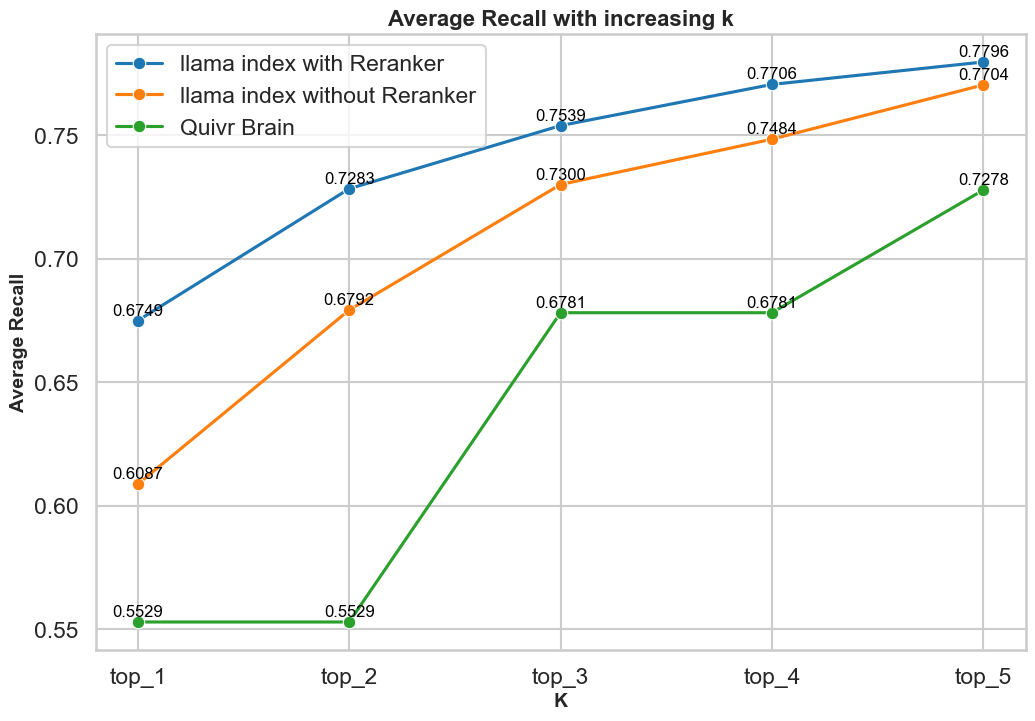

In [104]:
print("Mean Average Precision:\nwithout reranker : ", results.mean_map_metric, "\nwith reranker : ", results_reranker.mean_map_metric, "\nQuivr : ", results_quivr.mean_map_metric)
plot_mean_recall([results_reranker.mean_recall, results.mean_recall, results_quivr.mean_recall], labels=["llama index with Reranker", "llama index without Reranker", "Quivr Brain"])
